In [92]:
%matplotlib inline
%pylab inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.datasets import make_moons
from IPython.display import clear_output
from IPython import display
from time import sleep
from sklearn.metrics import precision_score, accuracy_score

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [86]:
def initialize(input_dimensions, hidden_dimensions, output_dimensions):
    input_nodes = input_dimensions + 1 # We add one to have room for bias node
    hidden_nodes = hidden_dimensions
    output_nodes = output_dimensions

    # Initilize arrays of 1s for activations 
    input_activations = np.ones(input_nodes)
    hidden_activations = np.ones(hidden_nodes)
    output_activations = np.ones(output_nodes)

    # Initialize randomized weights
    input_weights = np.random.randn(input_nodes, hidden_nodes)
    output_weights = np.random.randn(hidden_nodes, output_nodes)

    # Initialize a cache used to do store the last step size in backpropagation
    input_stepsize = np.zeros((input_nodes, hidden_nodes)) # Input x Hidden
    output_stepsize = np.zeros((hidden_nodes, output_nodes)) # Hidden x Output
    return (input_nodes, hidden_nodes, output_nodes,
           input_activations, hidden_activations, output_activations,
           input_weights, output_weights,
           input_stepsize, output_stepsize)

In [80]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1.0 - x)

In [81]:
def forward_propagation(inputs):
    if len(inputs) != input_nodes- 1:
        raise ValueError("Wrong number of inputs ;) ({} instead of {})".format(len(inputs), input_nodes - 1))

    # Set activations to be equal to new inputs
    for i in range(input_nodes - 1): # we subtract one in order not to touch the bias
        input_activations[i] = inputs[i]

    # Calculate the weighted value for each hidden neuron
    # Remember that in FFNs each neuron is connected to all neurons in the previous layer
    for i in range(hidden_nodes):
        value = 0.0
        for j in range(input_nodes):
            value += input_activations[j] * input_weights[j][i]

        hidden_activations[i] = sigmoid(value) # Apply the non-linear sigmoid function to the weighted value

    # Calculate the weighted value for each output neuron
    # !! Notice: This is almost the same as the step before !!
    for i in range(output_nodes):
        value = 0.0
        for j in range(hidden_nodes):
            value += hidden_activations[j] * output_weights[j][i]

        output_activations[i] = sigmoid(value) # Apply the non-linear sigmoid function once more

    return output_activations

In [82]:
def backward_propagation(targets, learning_rate):
    if len(targets) != output_nodes:
        raise ValueError("Wrong number of targets ;) ({} instead of {})".format(len(targets), output_nodes))

    # Initialize deltas used to choose the direction the weights should change
    output_deltas = np.zeros(output_nodes)
    hidden_deltas = np.zeros(hidden_nodes)

    # Update the deltas for the output layer
    for i in range(output_nodes):
        error = -(targets[i] - output_activations[i])
        output_deltas[i] = sigmoid_derivative(output_activations[i]) * error

    # Update the deltas or the hidden layer
    for i in range(hidden_nodes):
        error = 0.0
        for j in range(output_nodes):
            error += output_deltas[j] * output_weights[i][j]

        hidden_deltas[i] = sigmoid_derivative(hidden_activations[i]) * error

    # Update the weights connecting the hidden layer to the output layer
    for i in range(hidden_nodes):
        for j in range(output_nodes):
            change = output_deltas[j] * hidden_activations[i]
            output_weights[i][j] -= learning_rate * change + output_stepsize[i][j]
            output_stepsize[i][j] = change

    # Update the weights connecting the input layer to the hidden layer
    for i in range(input_nodes):
        for j in range(hidden_nodes):
            change = hidden_deltas[j] * input_activations[i]
            input_weights[i][j] -= learning_rate * change + input_stepsize[i][j]
            input_stepsize[i][j] = change

    # Calculate Mean Squared Error 
    error = sum(0.5 * (targets - output_activations) ** 2)

    return error

In [83]:
def train(patterns, epochs = 10, learning_rate = 0.002):
    error_per_epoch = []
    for i in range(epochs):
        error = 0.0

        for p in patterns:
            inputs, targets = p

            forward_propagation(inputs)
            error += backward_propagation(targets, learning_rate)
            
        error_per_epoch.append(error) 
    
    return error_per_epoch

def predict(X):
    predictions = []

    for x in X:
        pred = forward_propagation(x)
        pred = np.argmax(pred)
        predictions.append(pred)
    return np.array(predictions)

In [117]:
def mesh_grid(X, step_size=0.08):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, step_size),
                         np.arange(y_min, y_max, step_size))
    
def prediction_contours(xx, yy):
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    return Z.reshape(xx.shape)
    
def cost(inputs, targets):
    predictions = []
    for x in inputs:
        predictions.append(forward_propagation(x))
        
    return sum(0.5 * (targets - np.array(predictions)) ** 2)
    
def train_with_animation(train_data, test_data, epochs = 10, learning_rate = 0.002, fast=False):
    num_frames = epochs

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))
    ax1.set_title("Train Targets")
    
    X_train, Y_train = zip(*train_data)
    Y_train = [np.argmax(l) for l in Y_train]
    X_train = np.array(X_train)

    # create a mesh to plot in
    xx_train, yy_train = mesh_grid(X_train)

    
    ax1.scatter(X_train[:, 0], X_train[:, 1], s=60, cmap=plt.cm.coolwarm)
    
    X_test, Y_orig = zip(*test_data)
    Y_test = [np.argmax(l) for l in Y_orig]
    X_test = np.array(X_test)
    
    # create a mesh to plot in
    xx_test, yy_test = mesh_grid(X_test)
    
    test_scat = ax2.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, s=60, cmap=plt.cm.coolwarm)

    train_error = []
    test_error = []
    for i in range(1, epochs + 1):
        error = 0.0
        
        for p in train_data:
            inputs, targets = p
            
            forward_propagation(inputs)
            error += backward_propagation(targets, learning_rate)
        
        plt.suptitle("Epoch: {}, MSE: {}".format(i, error), fontsize=14, fontweight='bold')
        
        ax1.cla()
        pred_train = predict(X_train)
        train_precision = precision_score(Y_train, pred_train)
        train_accuracy = accuracy_score(Y_train, pred_train)
        ax1.set_title("Train Precision: {0:0.2f}, Train Accuracy: {1:0.2f}".format(train_precision, train_accuracy))
        ax1.scatter(X_train[:, 0], X_train[:, 1], s=60, c=Y_train, cmap=plt.cm.coolwarm)
        ax1.contourf(xx_train, yy_train, prediction_contours(xx_train, yy_train), cmap=plt.cm.coolwarm, alpha=0.3)
        
        ax2.cla()
        pred_test = predict(X_test)
        test_precision = precision_score(Y_test, pred_test)
        test_accuracy = accuracy_score(Y_test, pred_test)
        ax2.set_title("Test Precision: {0:0.2f}, Test Accuracy: {1:0.2f}".format(test_precision, test_accuracy))
        ax2.scatter(X_test[:, 0], X_test[:, 1], s=60, c=Y_test, cmap=plt.cm.coolwarm)
        ax2.contourf(xx_test, yy_test, prediction_contours(xx_test, yy_test), cmap=plt.cm.coolwarm, alpha=0.3)

        train_error.append(error)
        test_error.append(cost(X_test, Y_orig))
        
        ax3.cla()
        ax3.plot(train_error, label="Train Error")
        ax3.plot(test_error, label="Test Error")
        ax3.legend()
        
        display.clear_output(wait=True)
        display.display(plt.gcf())    

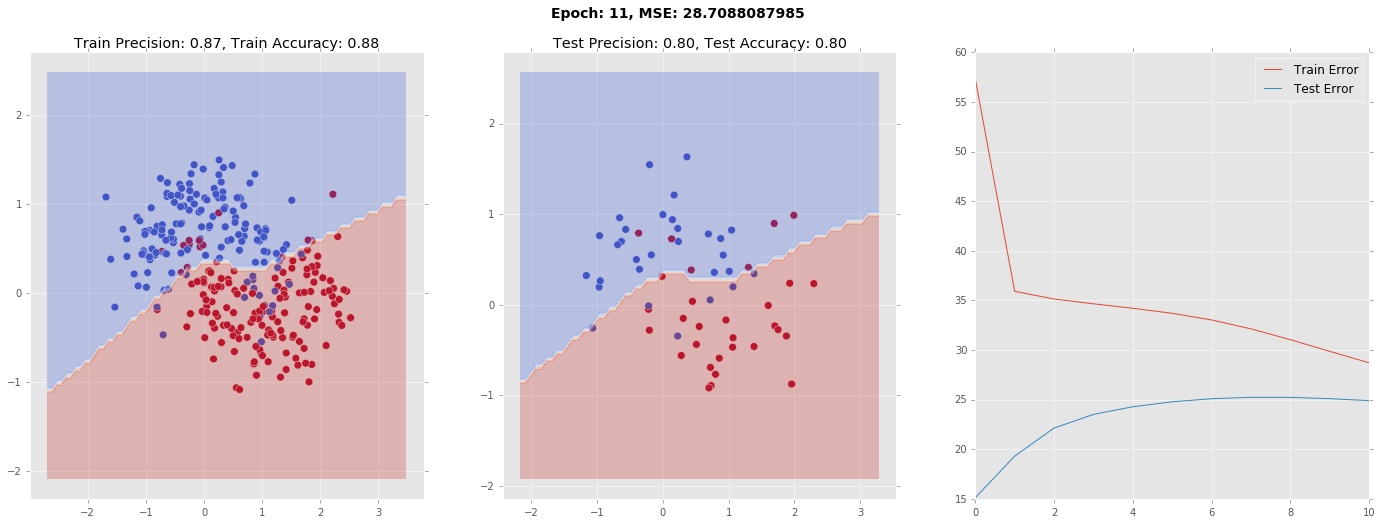

KeyboardInterrupt: 

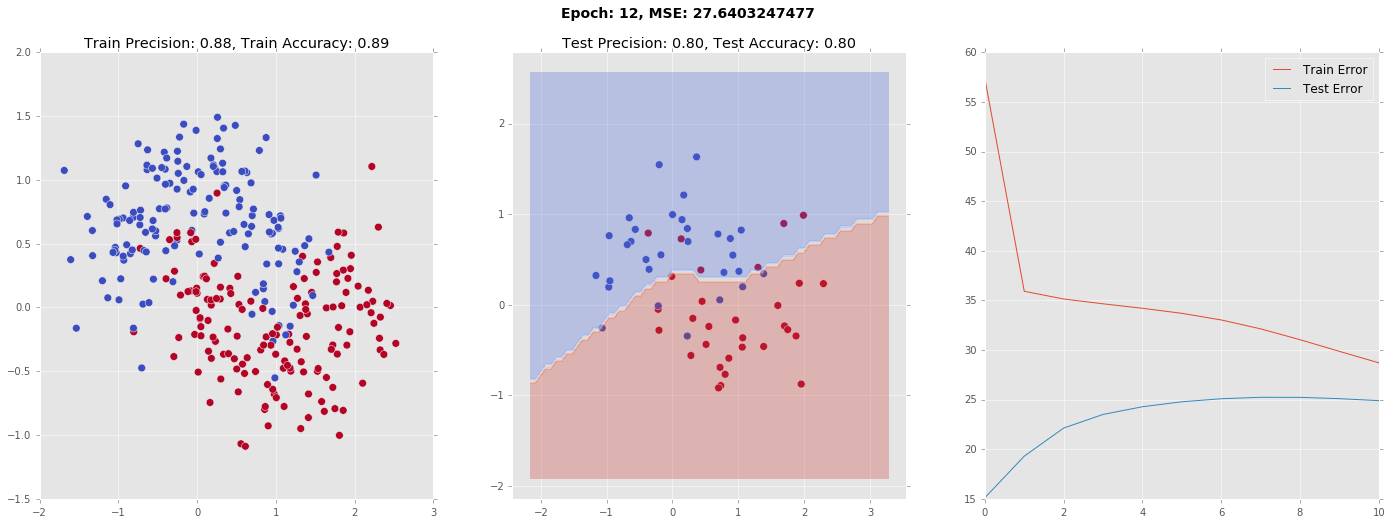

In [118]:
np.random.seed(0)

input_dimensions = 2
hidden_dimensions = 10
output_dimensions = 2

train_size = 300
test_size = 60
noise = 0.30

epochs = 60
learning_rate = 0.1

input_nodes, hidden_nodes, output_nodes,\
input_activations, hidden_activations, output_activations,\
input_weights, output_weights,\
input_stepsize, output_stepsize = initialize(input_dimensions, hidden_dimensions, output_dimensions)

X_train, Y_train = make_moons(train_size, noise=noise)
X_test, Y_test = make_moons(test_size, noise=noise)

def one_hot(Y):
    oneHot = [np.zeros(2) for y in Y]
    for i, y in enumerate(Y):
        oneHot[i][y] = 1
    return oneHot

train_data = list(zip(X_train, one_hot(Y_train)))
test_data = list(zip(X_test, one_hot(Y_test)))

train_with_animation(train_data, test_data, epochs=epochs, learning_rate=learning_rate)

In [77]:
from pprint import pprint

def softmax(values):
    exp_scores = np.exp(values)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def cross_entropy(model, X, Y, regularization):
    hidden_weights, output_weights = model['HW'], model['OW']
    probs = predict(model, X, get_probs=True)
    
    num_examples = len(Y)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), Y])
    data_loss = np.sum(corect_logprobs)
    
    # Add regulatization term to loss (optional)
    data_loss += (regularization / 2) * (np.sum(np.square(hidden_weights)) + np.sum(np.square(output_weights)))
    
    return 1./num_examples * data_loss

def predict(model, x, get_probs=False):
    hidden_weights, hidden_bias, output_weights, output_bias = model['HW'], model['HB'], model['OW'], model['OB']
    # Forward propagation
    hidden_values = x.dot(hidden_weights) + hidden_bias
    hidden_activations = np.tanh(hidden_values)
    output_values = hidden_activations.dot(output_weights) + output_bias
    
    probs = softmax(output_values)
    if get_probs:
        return probs
    
    return np.argmax(probs, axis=1)

def prediction_contours(model, xx, yy):
    Z = predict(model, np.c_[xx.ravel(), yy.ravel()])
    return Z.reshape(xx.shape)

def extract_data(data):
    X, Y = zip(*data)
    X, Y = np.array(X), np.array(Y)
    return X, Y

def plot(model, ax, X, Y, title):
    preds = predict(model, X)
    precision = precision_score(Y, preds)
    accuracy = accuracy_score(Y, preds)
    ax.set_title("{0} Precision: {1:0.2f}, {0} Accuracy: {2:0.2f}".format(title, precision, accuracy))
    ax.scatter(X[:, 0], X[:, 1], s=60, c=Y, cmap=plt.cm.coolwarm)
    return ax

def build_model(train_data, 
                test_data,
                input_dimensions = 2,
                hidden_dimensions = 3,
                output_dimensions = 2,
                epochs = 1000,
                learning_rate = 0.01,
                regularization = 0.01):
    
    X_train, Y_train = extract_data(train_data)
    X_test, Y_test = extract_data(test_data)
    
    # create a mesh to plot in
    xx_train, yy_train = mesh_grid(X_train)
    xx_test, yy_test = mesh_grid(X_test)
    
    # Define the necessary weights and biases
    hidden_weights = np.random.randn(input_dimensions, hidden_dimensions) / np.sqrt(input_dimensions)
    hidden_bias = np.zeros((1, hidden_dimensions))
    
    output_weights = np.random.randn(hidden_dimensions, output_dimensions) / np.sqrt(hidden_dimensions)
    output_bias = np.zeros((1, output_dimensions))
    
    model = { 
        "HW": hidden_weights,
        "Hb": hidden_bias,
        "OW": output_weights,
        "OB": output_bias
    }
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))
    ax1.scatter(X_train[:, 0], X_train[:, 1], s=60, cmap=plt.cm.coolwarm)
    ax2.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, s=60, cmap=plt.cm.coolwarm)
    
    test_loss = []
    train_loss = []
    for i in range(1, epochs + 1):
        # Forward propagation
        hidden_values = X_train.dot(hidden_weights) + hidden_bias
        hidden_activations = np.tanh(hidden_values)
        output_values = hidden_activations.dot(output_weights) + output_bias
        probs = softmax(output_values)

        # Backpropagation
        output_delta = probs
        output_delta[range(len(X_train)), Y_train] -= 1
        output_weights_delta = (hidden_activations.T).dot(output_delta)
        output_bias_delta = np.sum(output_delta, axis=0, keepdims=True)
        
        hidden_delta = output_delta.dot(output_weights.T) * (1 - np.power(hidden_activations, 2))
        hidden_weights_delta = np.dot(X_train.T, hidden_delta)
        hidden_bias_delta = np.sum(hidden_delta, axis=0)

        # Add regularization terms (the biases don't have regularization terms)
        output_weights_delta += regularization * output_weights
        hidden_weights_delta += regularization * hidden_weights

        # Gradient descent parameter update
        output_weights += -learning_rate * output_weights_delta
        output_bias += -learning_rate * output_bias_delta
        
        hidden_weights += -learning_rate * hidden_weights_delta
        hidden_bias += -learning_rate * hidden_bias_delta
        
        model = { 
            "HW": hidden_weights,
            "HB": hidden_bias,
            "OW": output_weights,
            "OB": output_bias
        }
        
        if i % (epochs / 20) == 0:
            plot(model, ax1, X_train, Y_train, "Train")
            plot(model, ax2, X_test, Y_test, "Test")

            ax1.contourf(xx_train, yy_train, prediction_contours(model, xx_train, yy_train), cmap=plt.cm.coolwarm, alpha=0.3)
            ax2.contourf(xx_test, yy_test, prediction_contours(model, xx_test, yy_test), cmap=plt.cm.coolwarm, alpha=0.3)
            
            ax3.cla()
            ax3.plot(test_loss,  label='Test Error')
            ax3.plot(train_loss, label='Train Error')
            mean_train_loss = np.array(train_loss[-10:]).mean()
            mean_test_loss = np.array(test_loss[-10:]).mean()
            ax3.set_title("Test Loss: {0:0.2f}, Train Loss {1:0.2f}".format(mean_test_loss, mean_train_loss))
            ax3.legend()

            display.clear_output(wait=True)
            display.display(plt.gcf())
        
        test_loss.append(cross_entropy(model, X_test, Y_test, regularization))
        train_loss.append(cross_entropy(model, X_train, Y_train, regularization))

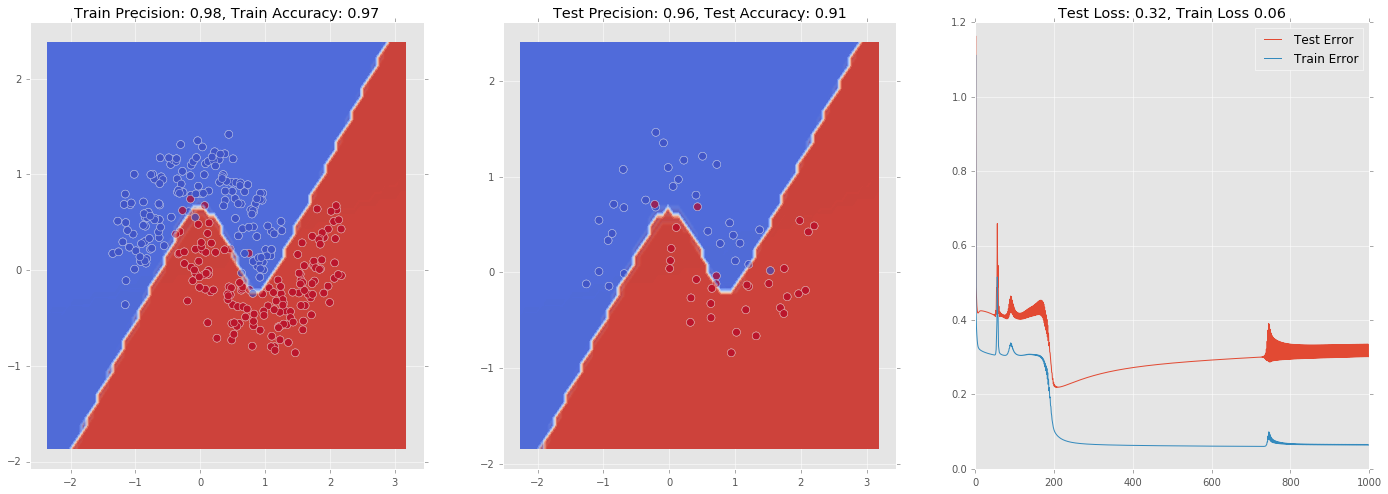

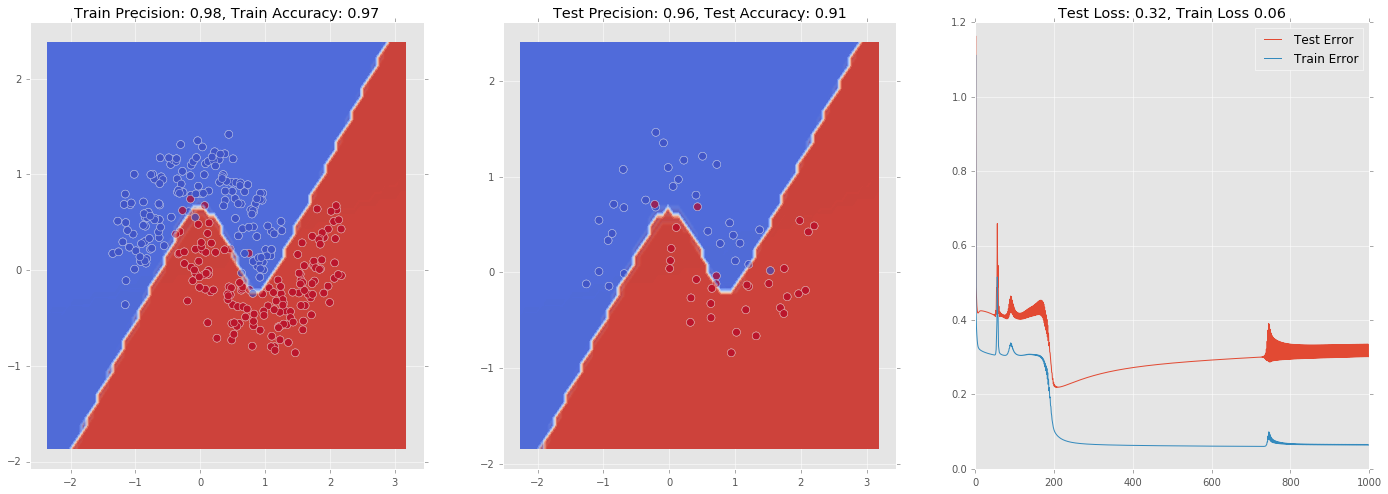

In [78]:
X_train, Y_train = make_moons(300, noise=0.2)
X_test, Y_test = make_moons(60, noise=0.2)


train_data = list(zip(X_train, Y_train))
test_data = list(zip(X_test, Y_test))

build_model(train_data, test_data)